### $\Large{\bm{\mathfrak{Task~~for ~~next~~ meet ~~ at~~23 ~~August~~ 2022}}}$

In this meet, i will try to bin stars on the basis of their distance. I will find red stars for 5 stars in each bin firstly, after that i will try to include more stars and will find the average number of stars within the bin.

In [1]:
# importing all necessary library

from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

### $\textbf{importing csv file of 1m sources containing Gaia data for plotting HR diagram}$


In [2]:
# importing csv file of 1m sources containing Gaia data for plotting HR diagram
filename = '1M.csv'
df1 = pd.read_csv(filename)

# filtering data on the basis of parallax error so that we can get better observed sources
df = df1[df1['parallax_error']< 0.1]
df = df.reset_index(drop=True)


gk_1m = df["phot_g_mean_mag"] - df["ks_m"]
mg = df["mg"]

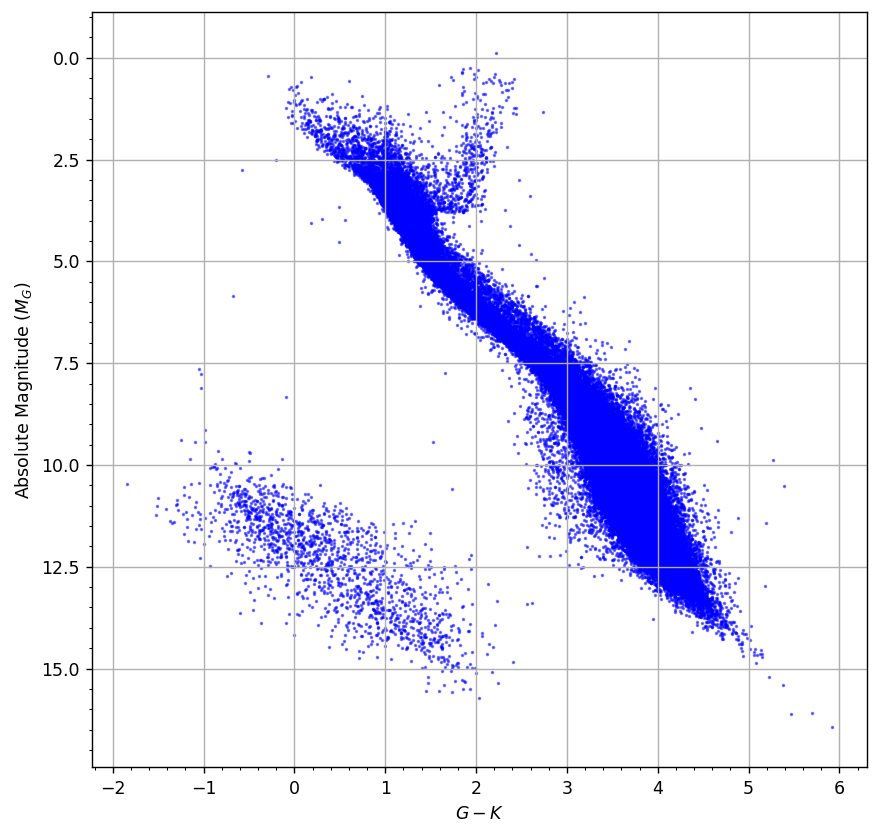

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 125, figsize = (8, 8))
ax.set_xlabel(r"$G - K$")
ax.set_ylabel(r"Absolute Magnitude ($M_G$)")
ax.scatter(gk_1m, mg, s = 1, alpha= 0.5, c = 'blue')
ax.minorticks_on()
ax.grid(True)
ax.set_ylim(max(mg) + 1, min(mg) - 1)
plt.show()

### $\textbf{Boundary equation}$

In [4]:
# Defining the equation of straight line for the boundries

#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------


def equation1(y):
    # y = 1 - 5 * (x - 2.5)
    x = 2.5 - 1.0/5.0 * (y - 1)
    return x

def equation2(y):
    # y = 4.5 + 4.0/1.9 * (x - 1.8)
    x = 1.8 + 1.9/4.0 * (y - 4.5)
    return x

def equation3(y):
    #y = 8.5 + 40/9 * (x - 3.7)
    x = 3.7 + 9.0/40.0 * (y - 8.5)
    return x


#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------

In [46]:
tauri = pd.read_csv('t tauri.csv')
tauri_star = tauri[["Name", "_RA", "_DE", "mag"]]

tauri_star = tauri_star.sort_values(by='mag')
tauri_star = tauri_star.reset_index(drop=True)

### $\textbf{Plotting those boundary line at HR Diagram}$

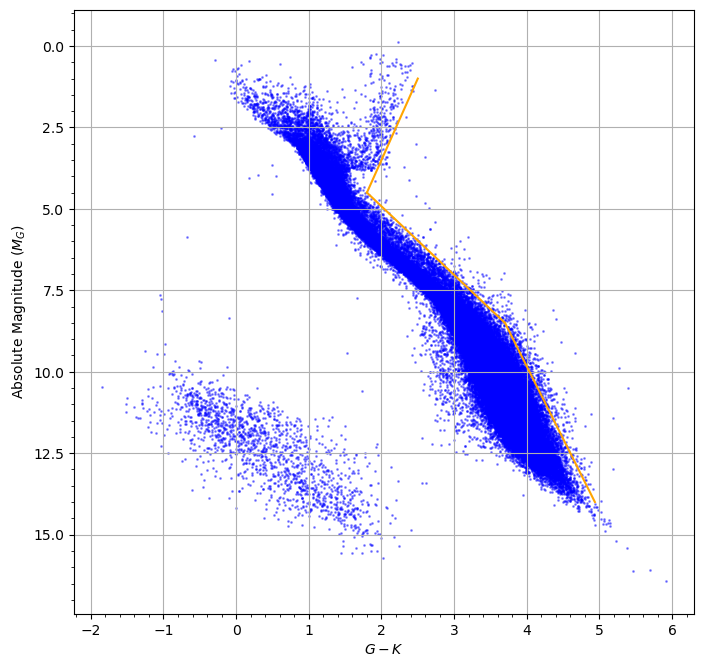

In [5]:
# defining the limit of absolute magnitude just for plotting the boundries line
y_values1 = np.linspace(1, 4.5, 50)
y_values2 = np.linspace(4.5, 8.5, 100)
y_values3 = np.linspace(8.5, 14.0, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)
ax.set_xlabel(r"$G - K$")
ax.set_ylabel(r"Absolute Magnitude ($M_G$)", fontsize = 10)

# Plotting the HR diagram for 1M sources
ax.scatter(gk_1m, mg, s = 1, alpha = 0.4, c = 'blue')

# plotting the boundries using the eqaution of straight line
ax.plot(equation1(y_values1), y_values1,  color = 'orange')
ax.plot(equation2(y_values2), y_values2,  color = 'orange')
ax.plot(equation3(y_values3), y_values3, color = 'orange')

ax.minorticks_on()
ax.grid(True)
ax.set_ylim(max(mg)+1, min(mg)-1)
plt.show()

### $ \bm{\textbf{Extracting data from the gaia table around a star having ra and dec}}$

In [47]:
# defining a function for extracting data of stars from GAIA database around a choosen Object(Star or Herbig Ae/Be star)

# The function will take input query size, ra, dec of the centered boject and radius of the circle
# It will give output of ojects around that star in table form

def get_gaia_result(query_size, ra_obj, dec_obj, radius_deg):
    #from astroquery.gaia import Gaia

    query = """SELECT TOP {}""".format(query_size) + """
        g.source_id, g.ra, g.dec, g.parallax, g.parallax_error, d3.r_med_photogeo, d3.r_lo_photogeo, d3.r_hi_photogeo,(d3.r_hi_photogeo - d3.r_lo_photogeo)/(2 * d3.r_med_photogeo) AS dist_frac, g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag, g.bp_rp, g.phot_g_mean_mag + 5*log10(g.parallax) - 10 AS mv,
        w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro, tt.j_m, tt.h_m, tt.ks_m
        FROM gaiadr2.gaia_source as g, gaiadr2.allwise_best_neighbour as x, allwise_original_valid as w, gaiadr2.tmass_best_neighbour as t, tmass_original_valid as tt, external.gaiaedr3_distance AS d3
        WHERE CONTAINS(POINT(g.ra, g.dec), CIRCLE({}""".format(ra_obj) + """, {}""".format(dec_obj)+""", {}""".format(radius_deg) + """ )) = 1 AND g.parallax > 0.0 AND
        g.parallax IS NOT NULL AND g.bp_rp IS NOT NULL AND ((g.source_id = x.source_id AND x.allwise_oid = w.allwise_oid) AND (g.source_id = t.source_id AND t.tmass_oid = tt.tmass_oid)) AND (g.source_id = d3.source_id)
        """

    job = Gaia.launch_job(query)
    result = job.get_results()

    return result

### $\textbf{Counting function}$

In [7]:
# Defining a function which will count red object
# just we need to pass list of object(stars) with G-K as X- coordinate and Absolute Magnitude(Mv) as Y-coordinate 

def counting_fun(her_mg, her_gk):

    count_red = 0

    for i in range(len(her_mg)):

        if her_mg[i] <= 4.5:
            if her_gk[i] >= equation1(her_mg[i]):
                count_red = count_red + 1
        
        if 4.5 < her_mg[i] and her_mg[i] <= 8.5:
            if her_gk[i] >= equation2(her_mg[i]):
                count_red = count_red + 1

        if 8.5 < her_mg[i]:
            if her_gk[i] >= equation3(her_mg[i]):
                count_red = count_red + 1


    return count_red

In [52]:
dd = get_gaia_result(1000, tauri_star["_RA"][1], tauri_star["_DE"][1], 6.0/60.0)

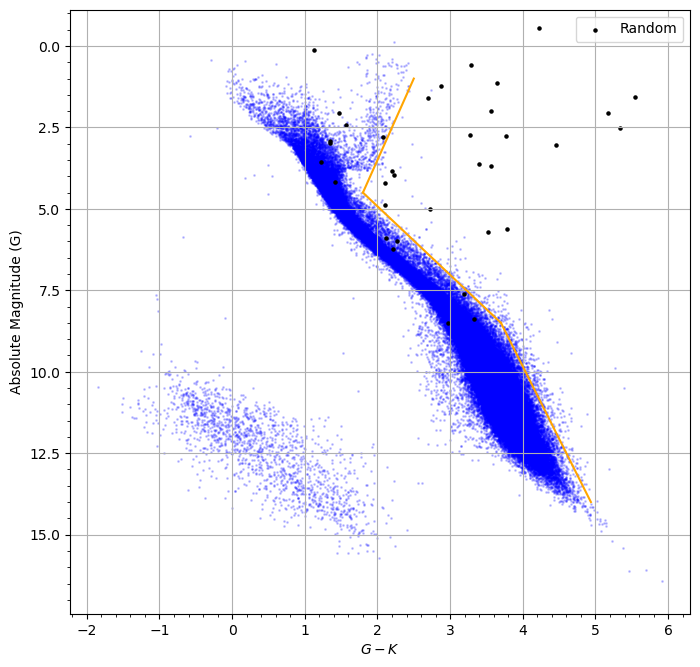

In [53]:
# %matplotlib inline

# Obtaining G-K and Absolute Magnitue (Mv) for Random star and Herbig Ae/Be Star
rand_gk = dd['phot_g_mean_mag'] - dd['ks_m']
rand_mg = dd['mv']

# her_gk = result_her["phot_g_mean_mag"] - result_her['ks_m']
# her_mg = result_her["mv"]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 8), dpi = 100)


ax.set_xlabel(r"$G - K$")
ax.set_ylabel("Absolute Magnitude (G)", fontsize = 10)

# Plotting the HR diagram for 1M sources
ax.scatter(gk_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')

# plotting the lines using just two points 

# ax.plot([1.8, 2.5], [4.5, 1], color = 'red')
# ax.plot([1.8, 3.7], [4.5, 8.5], color = 'red')
# ax.plot([3.7, 4.6], [8.5, 12.5], color = 'red')

# plotting the boundries using the eqaution of straight line
ax.plot(equation1(y_values1), y_values1,  color = 'orange')
ax.plot(equation2(y_values2), y_values2,  color = 'orange')
ax.plot(equation3(y_values3), y_values3, color = 'orange')

# plotting/Placing herbig's surrounding stars in HR diagram(CMD)
ax.scatter(rand_gk, rand_mg, marker='o', color = 'k', s = 5, label = 'Random')
# ax.scatter(her_gk, her_mg, marker='+', color = 'r', s = 5, label = 'HAeBe')

ax.minorticks_on()
ax.grid(True)
ax.legend()
ax.set_ylim(max(df.mg)+1, min(df.mg) -1)
plt.show()

### $\textbf{Importing a list of herbig Ae/Be stars from "Vioque M." Catalog}$

### $\textbf{J/A+A/620/A128/hqsample}$

In [8]:
df_herb = pd.read_csv("all_herbig star.csv")

In [9]:
df_herb.head()

,recno,Name,RAICRS,DEICRS,plx,e_plx,Dist,E_Dist,e_Dist,Teff,...,E(H),E(Ks),E(W1),E(W2),E(W3),E(W4),The,SimbadName,_RA_icrs,_DE_icrs
0,1,AB Aur,73.941250,30.551111,6.139962,0.057095,162.9,2.6,2.4,9500,...,6.01,13.23,28.77,NaN,240.49,2244.34,Yes,AB Aur,73.941250,30.551111
1,2,AK Sco,253.686667,-36.888611,7.112617,0.062137,140.6,2.1,2.0,6250,...,1.88,3.14,7.78,11.61,49.83,400.83,,AK Sco,253.686667,-36.888611
2,3,AS 310,278.338333,-4.968333,0.390395,0.045659,2108.4,354.5,235.6,24500,...,0.71,0.81,NaN,NaN,NaN,NaN,Yes,AS 310,278.338333,-4.968333
3,4,AS 470,324.059167,57.358611,0.137445,0.026643,4039.6,616.9,439.7,8150,...,1.28,1.71,2.15,2.77,3.21,5.36,,AS 470,324.059167,57.358611
4,5,AS 477,328.142083,47.228889,1.289931,0.028924,773.0,30.2,26.6,10000,...,NaN,NaN,27.30,59.04,104.62,475.86,Yes,AS 477,328.142083,47.228889


### $\textbf{Filtering out these herbig stars on the basis of different parameters}$

$\textbf{Like - parallax error, error in distance, within 500 parsec}$

In [10]:
# filtering out on the basis of parallax error i.e. parallax_error < 0.1
df_herb = df_herb[df_herb["e_plx"]< 0.1] 

# resetting the index of the table
df_herb = df_herb.reset_index(drop=True)
df_herb

,recno,Name,RAICRS,DEICRS,plx,e_plx,Dist,E_Dist,e_Dist,Teff,...,E(H),E(Ks),E(W1),E(W2),E(W3),E(W4),The,SimbadName,_RA_icrs,_DE_icrs
0,1,AB Aur,73.941250,30.551111,6.139962,0.057095,162.9,2.6,2.4,9500,...,6.01,13.23,28.77,NaN,240.49,2244.34,Yes,AB Aur,73.941250,30.551111
1,2,AK Sco,253.686667,-36.888611,7.112617,0.062137,140.6,2.1,2.0,6250,...,1.88,3.14,7.78,11.61,49.83,400.83,,AK Sco,253.686667,-36.888611
2,3,AS 310,278.338333,-4.968333,0.390395,0.045659,2108.4,354.5,235.6,24500,...,0.71,0.81,NaN,NaN,NaN,NaN,Yes,AS 310,278.338333,-4.968333
3,4,AS 470,324.059167,57.358611,0.137445,0.026643,4039.6,616.9,439.7,8150,...,1.28,1.71,2.15,2.77,3.21,5.36,,AS 470,324.059167,57.358611
4,5,AS 477,328.142083,47.228889,1.289931,0.028924,773.0,30.2,26.6,10000,...,NaN,NaN,27.30,59.04,104.62,475.86,Yes,AS 477,328.142083,47.228889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,214,VV Ser,277.199583,0.144444,2.380821,0.045769,419.7,14.0,12.6,13800,...,8.83,21.97,46.08,121.07,428.03,1766.30,Yes,VV Ser,277.199583,0.144444
189,215,VX Cas,7.877917,61.980833,1.861109,0.036601,536.6,18.3,16.4,10000,...,4.62,11.25,27.13,45.17,276.95,2735.55,Yes,VX Cas,7.877917,61.980833
190,216,WRAY 15-1435,243.277917,-50.388889,0.466778,0.048112,1858.3,300.1,200.1,24500,...,2.88,3.34,4.39,7.36,192.05,3602.51,,WRAY 15-1435,243.277917,-50.388889
191,217,WW Vul,291.495000,21.208611,1.983958,0.036763,503.5,16.2,14.5,8970,...,4.60,10.53,17.32,32.02,231.68,1366.23,Yes,WW Vul,291.495000,21.208611


In [11]:

herbig_5 = df_herb[["Name", "RAICRS", "DEICRS", "Dist", "E_Dist", "e_Dist"]]

# Creating a column for storing Maximum possible distance of the herbig star from the given error

herbig_5["Max_Dist"] = herbig_5["Dist"] + herbig_5["E_Dist"]


# Creating a column for storing Minimum possible distance of the herbig star from the given error
herbig_5["Min_Dist"] = herbig_5["Dist"]- herbig_5["e_Dist"]

/tmp/ipykernel_13083/1950939047.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  herbig_5["Max_Dist"] = herbig_5["Dist"] + herbig_5["E_Dist"]
/tmp/ipykernel_13083/1950939047.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  herbig_5["Min_Dist"] = herbig_5["Dist"]- herbig_5["e_Dist"]


### $\textbf{Filtering out on the basis of distance error}$

In [12]:
herbig_5 = herbig_5[(herbig_5["Max_Dist"] - herbig_5["Min_Dist"])/(2*herbig_5["Dist"])< 0.1]

### $\textbf{Importing 5 Random and 5 Herbig Ae/Be Stars}$


$\textbf{first bin --- distance wthin,  0 - 500 parsec}$

In [13]:

# Aranging the data in ascending order of distance
herbig_5 = herbig_5.sort_values(by="Dist")
herbig_5.reset_index(drop=True)

,Name,RAICRS,DEICRS,Dist,E_Dist,e_Dist,Max_Dist,Min_Dist
0,HD 100453,173.272917,-54.324722,104.2,0.7,0.7,104.9,103.5
1,HD 104237,180.020417,-78.193056,108.4,1.1,1.1,109.5,107.3
2,HD 100546,173.355417,-70.194722,110.0,1.0,1.0,111.0,109.0
3,HD 141569,237.490417,-3.921389,110.6,0.9,0.9,111.5,109.7
4,HD 169142,276.124167,-29.780556,114.0,1.4,1.3,115.4,112.7
...,...,...,...,...,...,...,...,...
144,PDS 34,132.493750,-45.885000,2132.9,135.9,111.8,2268.8,2021.1
145,MWC 655,339.632500,55.834722,2170.0,249.6,182.0,2419.6,1988.0
146,PDS 344,175.136667,-64.535000,2439.5,173.0,139.7,2612.5,2299.8
147,HBC 7,10.855417,61.639722,2757.3,252.4,194.4,3009.7,2562.9


In [14]:
herbig_5 = herbig_5[herbig_5["Dist"]<500.0]
herbig_5 = herbig_5.reset_index(drop=True)

In [15]:
herbig_5

,Name,RAICRS,DEICRS,Dist,E_Dist,e_Dist,Max_Dist,Min_Dist
0,HD 100453,173.272917,-54.324722,104.2,0.7,0.7,104.9,103.5
1,HD 104237,180.020417,-78.193056,108.4,1.1,1.1,109.5,107.3
2,HD 100546,173.355417,-70.194722,110.0,1.0,1.0,111.0,109.0
3,HD 141569,237.490417,-3.921389,110.6,0.9,0.9,111.5,109.7
4,HD 169142,276.124167,-29.780556,114.0,1.4,1.3,115.4,112.7
...,...,...,...,...,...,...,...,...
71,HD 36408,83.058750,17.058056,435.1,34.5,27.1,469.6,408.0
72,HD 290500,82.450417,-0.395278,438.3,23.6,19.9,461.9,418.4
73,HD 290409,81.772917,0.418889,454.9,31.0,25.1,485.9,429.8
74,XY Per A,57.401250,38.981944,459.1,34.6,27.4,493.7,431.7


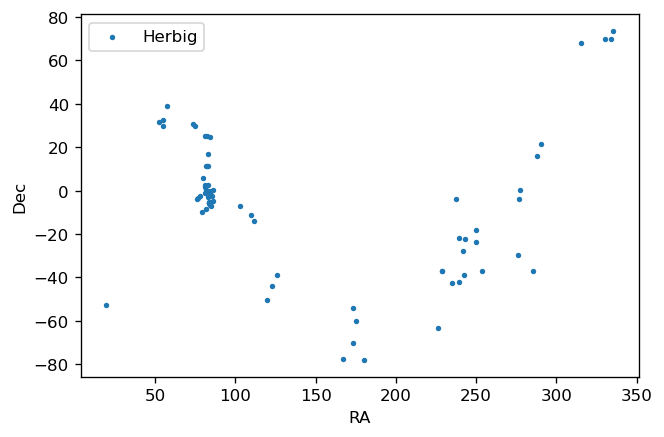

In [16]:
plt.figure(dpi = 120)
plt.scatter(herbig_5.RAICRS, herbig_5.DEICRS, s = 5,label = 'Herbig')
#plt.scatter(rnd_star20.ra, rnd_star20.dec, label = 'Random')
plt.legend()
plt.ylabel("Dec")
plt.xlabel("RA")
plt.show()

### $\textbf{Importing a list of random star}$

In [17]:
df_rand = pd.read_csv("test_star.csv")
df_rand.head()

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,phot_g_mean_mag
0,1934658092817644928,343.009122,43.312519,9.684125,0.142506,107.303535,105.959970,108.506714,4.192946
1,1451072022557616000,209.142558,27.491873,5.198965,0.146093,189.101850,185.861240,192.102070,4.436439
2,1547080896862730112,184.952870,48.984171,4.878467,0.138663,194.069200,191.403100,196.837040,4.445887
3,1372702716380418688,237.808001,35.655882,33.232806,0.108291,29.973818,29.905025,30.046097,4.460237
4,2911168969701511424,90.815329,-26.284174,8.127429,0.103540,128.580900,127.537250,129.590520,4.486209


### $\textbf{filtering out the data}$

In [18]:
df_rand = df_rand[(df_rand["parallax_error"] < 0.1) & (df_rand["r_med_photogeo"] < 500.0)]

In [19]:
df_rand = df_rand[((df_rand["r_hi_photogeo"] - df_rand["r_lo_photogeo"])/(2*df_rand["r_med_photogeo"])) < 0.1]

In [20]:
df_rand

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,phot_g_mean_mag
8,2143019566369485440,288.479586,57.704764,19.432855,0.098815,51.540665,51.221886,51.838688,4.606394
13,5276027024288944128,124.578582,-65.613098,11.021877,0.098481,91.461820,91.015920,91.979210,4.674393
16,5838154100636182016,181.956237,-75.366935,6.910939,0.091615,151.324050,149.836260,152.871800,4.694582
19,2087828961746272768,300.339958,50.104717,7.227106,0.085286,138.095280,136.797410,139.108370,4.705251
20,4976574143405173504,0.333882,-50.337319,5.158155,0.099975,185.544340,183.645310,188.155410,4.707014
...,...,...,...,...,...,...,...,...,...
999988,6447711046284095104,301.255599,-57.142653,5.282354,0.037899,192.468640,191.965520,192.898640,10.949389
999991,291499292940592640,26.579654,25.098231,8.206038,0.046091,120.941605,120.722565,121.188820,10.949393
999993,4154417484853608576,274.713102,-10.506375,2.016494,0.054263,484.624630,480.908940,488.696530,10.949393
999994,675227412222354048,118.887687,23.508739,3.659743,0.037046,266.092650,263.830380,268.221920,10.949394


In [21]:
df_rand = df_rand[df_rand["r_med_photogeo"]>100.0]


In [22]:
df_rand = df_rand.reset_index(drop=True)

### $\textbf{selecting only top 100 rows from the dataframe}$

In [23]:
df_5 = df_rand.head(100)

In [24]:
df_5 = df_5.sort_values(by = "r_med_photogeo")
df_5 = df_5.reset_index(drop=True)

In [25]:
pd.set_option('display.max_rows', 100)
df_5

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,phot_g_mean_mag
0,2267990637800956416,281.444946,74.085901,9.760830,0.059265,102.817530,102.005940,103.403170,4.957585
1,477209491229638528,65.167732,65.140422,9.490805,0.096039,106.125250,105.402030,106.787660,5.018244
2,4534818718162962304,284.939929,26.230357,9.768857,0.096862,106.651010,105.978010,107.322980,4.817640
3,4568140654982359424,256.574738,22.083991,9.301517,0.075648,107.419930,106.897026,107.955154,5.105988
4,4784427339626712704,70.693188,-50.481186,9.586010,0.096362,108.589310,107.613180,109.557430,4.999612
5,1366858193604257792,264.157097,48.585903,9.336958,0.073018,109.688760,109.006714,110.307490,4.965094
6,2142873125164535296,287.919322,56.859405,9.153303,0.086734,111.705400,110.660675,112.839740,4.821311
7,4581613864310894592,265.617916,24.563610,8.855957,0.095868,114.292100,113.355460,114.986570,4.973442
8,5512568607203077120,121.265474,-53.107933,8.622714,0.064121,116.624030,115.945206,117.265810,5.055114
9,2901273846086933888,84.957580,-32.629352,8.644626,0.068243,117.141655,116.475586,117.889620,5.174418


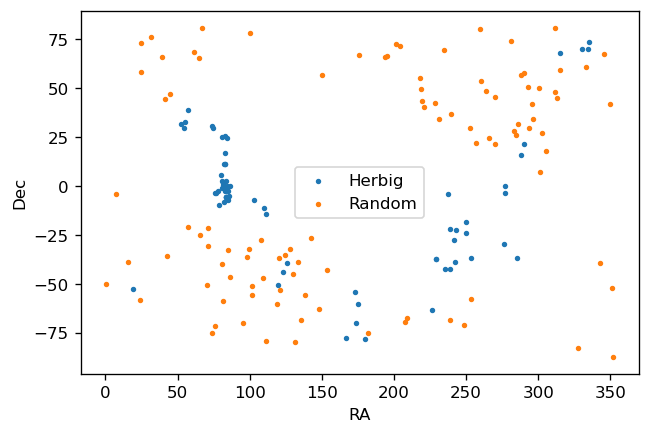

In [26]:
plt.figure(dpi = 120)
plt.scatter(herbig_5.RAICRS, herbig_5.DEICRS, s = 5,label = 'Herbig')
plt.scatter(df_5["ra"], df_5["dec"], label = 'Random', s = 5)
plt.legend()
plt.ylabel("Dec")
plt.xlabel("RA")
plt.show()

In [27]:
herb5 = herbig_5.iloc[[0, 23, 24, 42, 75]]
star5 = df_5.iloc[[0, 48, 75, 94, 99]]

In [28]:
herb5 = herb5.reset_index(drop=True)

In [29]:
star5 = star5.reset_index(drop=True)

In [30]:
herb5

,Name,RAICRS,DEICRS,Dist,E_Dist,e_Dist,Max_Dist,Min_Dist
0,HD 100453,173.272917,-54.324722,104.2,0.7,0.7,104.9,103.5
1,HD 97048,167.013333,-77.654722,184.8,2.2,2.1,187.0,182.7
2,HD 179218,287.797083,15.787500,266.0,5.6,5.2,271.6,260.8
3,BO Cep,334.225417,70.062500,374.5,4.7,4.5,379.2,370.0
4,HD 36917,83.695833,-5.570833,474.0,29.3,24.1,503.3,449.9


In [31]:
star5

,source_id,ra,dec,parallax,parallax_error,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,phot_g_mean_mag
0,2267990637800956416,281.444946,74.085901,9.760830,0.059265,102.81753,102.00594,103.40317,4.957585
1,4807445203237266944,80.850251,-39.678391,5.660871,0.092097,186.14750,184.61987,187.73296,4.778556
2,4717433855627617152,24.186840,-58.270968,3.956416,0.098888,267.50058,263.13376,271.36170,5.139260
3,2047135280516690944,296.159071,34.414174,2.875956,0.099060,374.86493,368.74805,380.33554,5.019116
4,1836489640252776576,302.949899,26.808947,1.932816,0.077865,488.34436,473.06480,503.21020,5.007190


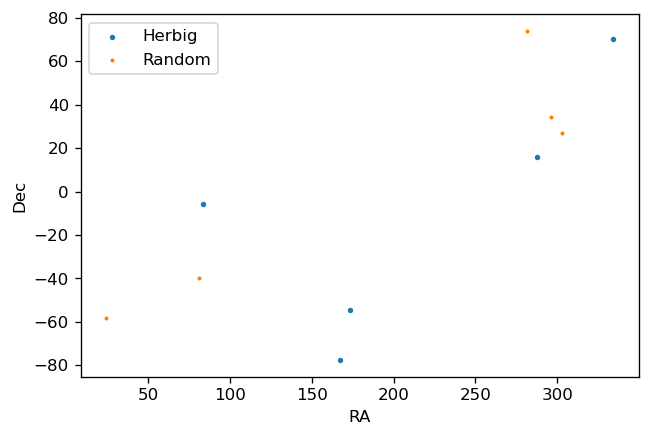

In [32]:
plt.figure(dpi = 120)
plt.scatter(herb5.RAICRS, herb5.DEICRS, s = 5,label = 'Herbig')
plt.scatter(star5["ra"], star5["dec"], label = 'Random', s = 2)
plt.legend()
plt.ylabel("Dec")
plt.xlabel("RA")
plt.show()

In [33]:
one_coord = SkyCoord(df.ra, df.dec, unit = (u.deg, u.deg))
herb_coord= SkyCoord(herb5.RAICRS, herb5.DEICRS, unit = (u.deg, u.deg))
rand_coord = SkyCoord(star5.ra, star5.dec, unit = (u.deg, u.deg))

# Converting to galactic coordinate in degrees

one_gal = one_coord.transform_to('galactic')
herb_gal = herb_coord.transform_to('galactic')
rand_gal = rand_coord.transform_to('galactic')


l_one = one_gal.l.radian
l_one[l_one > np.pi] -= 2.0*np.pi
b_one = one_gal.b.radian


l_herb = herb_gal.l.radian
l_herb[l_herb > np.pi] -= 2.0*np.pi
b_herb = herb_gal.b.radian


l_rand = rand_gal.l.radian
l_rand[l_rand > np.pi] -= 2.0*np.pi
b_rand = rand_gal.b.radian



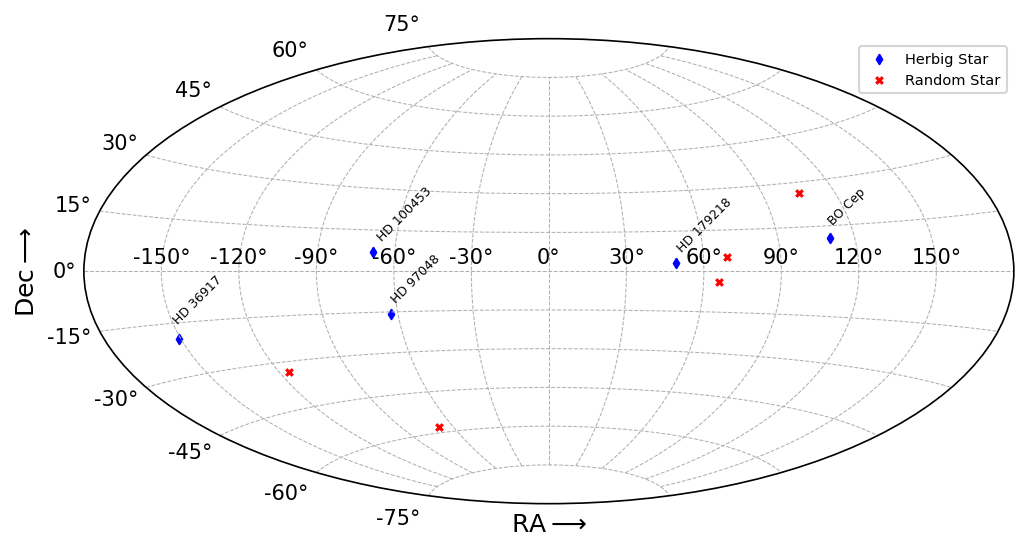

In [34]:
fig = plt.figure(figsize = [8, 5], dpi = 150)
ax = fig.add_subplot(1, 1, 1, projection='aitoff')
# ax.scatter(l_one, b_one, s = 1, color = 'orange', alpha = 0.1 )
ax.scatter(l_herb, b_herb, s = 10, color ='blue', marker = 'd', label = 'Herbig Star')
ax.scatter(l_rand, b_rand, s = 10, color = 'red', marker = "x", label = 'Random Star')
for i in range(len(l_herb)):
    ax.text(l_herb[i], b_herb[i]+ 0.08, '{}'.format(herb5["Name"][i]), fontsize = 6, rotation = 45)
ax.legend(fontsize = 7)
ax.minorticks_on()
ax.grid(True, linewidth = 0.5, linestyle = '--')
ax.set_xlabel(r'$\mathrm{RA}\longrightarrow$')
ax.xaxis.label.set_fontsize(12)
ax.set_ylabel(r'$\mathrm{Dec}\longrightarrow$')
ax.yaxis.label.set_fontsize(12)
# plt.savefig('posi.pdf', dpi = 500)
plt.show()


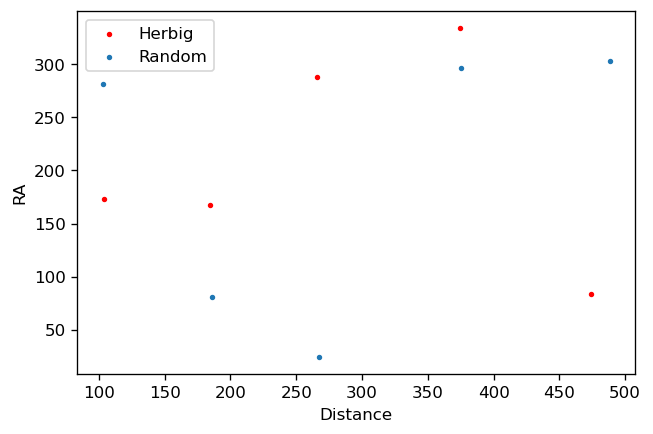

In [35]:
plt.figure(dpi = 120)

plt.scatter(herb5.Dist, herb5.RAICRS,  s = 5,label = 'Herbig',c = 'r')
plt.scatter(star5["r_med_photogeo"], star5["ra"],  label = 'Random', s = 5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("RA")
plt.show()


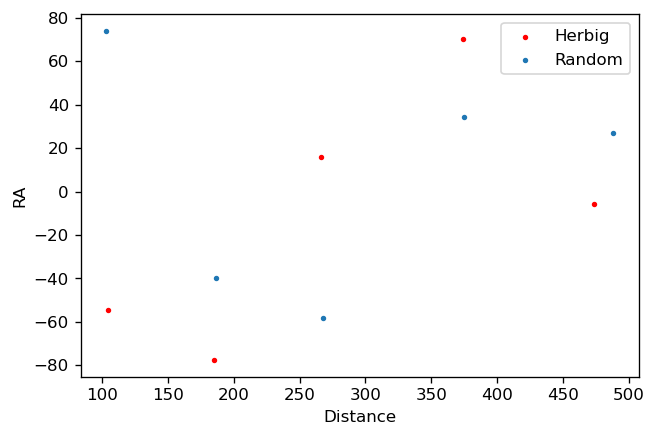

In [36]:
plt.figure(dpi = 120)
plt.scatter(herb5.Dist, herb5.DEICRS,  s = 5,label = 'Herbig',c = 'r')
plt.scatter(star5["r_med_photogeo"], star5["dec"],  label = 'Random', s = 5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("RA")
plt.show()

In [37]:
def plot_function(ra, dec, dist, id):


    rad = 10.0 
    result = get_gaia_result(10000, ra, dec, rad/60.0)
    result = result[result["parallax_error"] < 0.3]


    res_gk = result["phot_g_mean_mag"] - result["ks_m"]
    res_mg = result["mv"]
    red_star = counting_fun(res_mg, res_gk)
    
    fig = plt.figure(figsize=(8,10), dpi=125)
    grid = plt.GridSpec(4, 3, wspace=0.4, hspace=0.4)
    # make subplots
    ax1 = plt.subplot(grid[0:2, 0:2])
    ax2 = plt.subplot(grid[2, 0:])
    ax3 = plt.subplot(grid[3, 0:])

    
    ax1.set_title("For random star, Source_id = {}".format(id), fontsize = 8)
    ax1.scatter(gk_1m, mg, c = 'blue', s=1, alpha=0.3)
    ax1.scatter(res_gk, res_mg, c = 'red', s = 5, label = 'red star = {}'.format(red_star))
    ax1.minorticks_on()
    ax1.grid(True)
    ax1.legend()
    ax1.set_ylim(max(df.mg)+1, -5)
    ax1.set_xlabel(r"$G - K~~\longrightarrow$", fontsize = 8)
    ax1.set_ylabel(r"Absolute Magnitude (G)$\longrightarrow$", fontsize = 7)
    ax1.plot(equation1(y_values1), y_values1,  color = 'orange')
    ax1.plot(equation2(y_values2), y_values2,  color = 'orange')
    ax1.plot(equation3(y_values3), y_values3, color = 'orange')

    

    ax2.scatter(result["r_med_photogeo"], result["ra"], c = 'red', s = 5)
    ax2.scatter(dist, ra, c = 'blue', s = 10)
    ax2.set_xlabel(r"Distance in parsec $\longrightarrow$", fontsize = 6)
    ax2.set_ylabel(r"ra $\longrightarrow$")

    # Filtering out the value 
    frac = 0.2
    result = result[result["r_med_photogeo"] < frac]
    

    res_gk = result["phot_g_mean_mag"] - result["ks_m"]
    res_mg = result["mv"]
    red_star = counting_fun(res_mg, res_gk)

    ax3.set_title("Stars after filterig out distance error, dist_error < {}".format(frac), fontsize = 6)
    ax3.scatter(result["r_med_photogeo"], result["ra"], c = 'green', s = 5, label = "No. of red star = {}".format(red_star))
    ax3.scatter(dist, ra, c = 'blue', s = 10)
    ax3.set_xlabel(r"Distance in parsec $\longrightarrow$", fontsize = 8)
    ax3.set_ylabel(r"ra $\longrightarrow$", fontsize = 8)
    ax3.legend()
    ax2.minorticks_on()
    ax3.minorticks_on()
    plt.show()

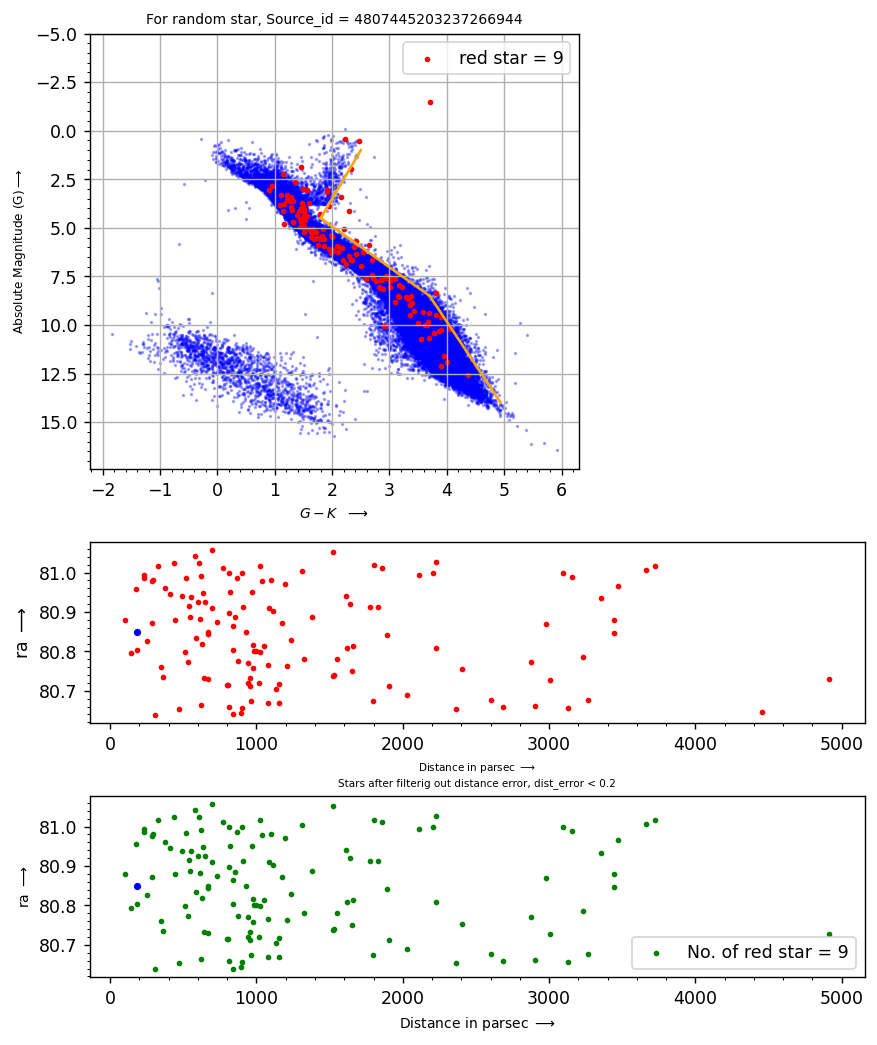

In [38]:
plot_function(star5["ra"][1], star5["dec"][1], star5["r_med_photogeo"][1], star5["source_id"][1])

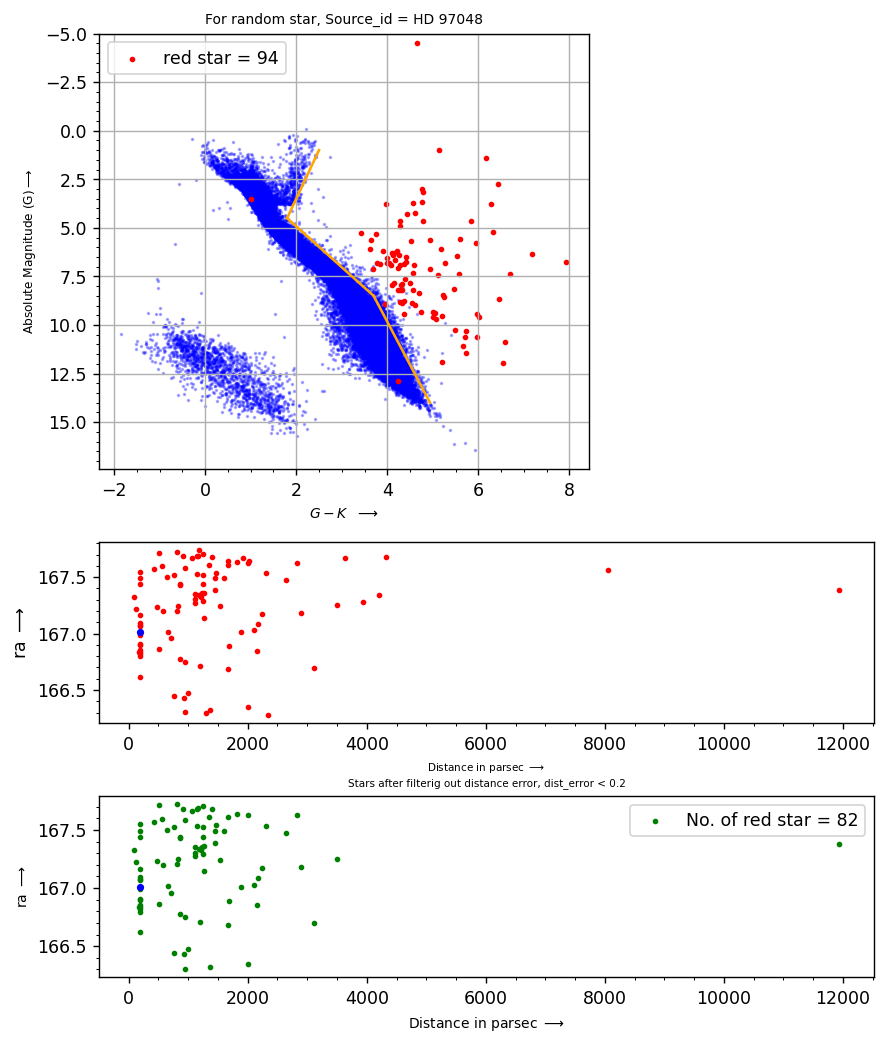

In [39]:
plot_function(herb5["RAICRS"][1], herb5["DEICRS"][1], herb5["Dist"][1], herb5["Name"][1])

In [40]:
%matplotlib inline

def list_red_object(radius):

    num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    num_red_star_her = []   # For red object around Herbig Ae/Be star
    num_tot_star_rand = []  # For toatal star around random star
    num_red_star_rand = []  # For red objec around the Random Star

    # After  distance filter

    after_num_tot_star_her = []  # Creating a numpy array for storing the total number of stars around a Herbig Ae/Be star
    after_num_red_star_her = []   # For red object around Herbig Ae/Be star
    after_num_tot_star_rand = []  # For toatal star around random star
    after_num_red_star_rand = []  # For red objec around the Random Star
    


    for i in range(len(herb5.RAICRS)):

        herbig_star = get_gaia_result(1000, herb5.loc[i][1], herb5.loc[i][2], radius)
        # Filtering out stars on the basis of parallax error
        herbig_star = herbig_star[herbig_star["parallax_error"] < 0.3]
        her_mg = herbig_star["mv"]
        her_gk = herbig_star["phot_g_mean_mag"] - herbig_star["ks_m"]

        after_herbig = herbig_star[herbig_star["dist_frac"] < 0.2]
        her_mg_af = after_herbig["mv"]
        her_gk_af = after_herbig["phot_g_mean_mag"] - after_herbig["ks_m"]
        



        rand_star = get_gaia_result(1000, star5.loc[i][1], star5.loc[i][2], radius)
        rand_star = rand_star[rand_star["parallax_error"] < 0.3]
        rand_mg = rand_star["mv"]
        rand_gk = rand_star["phot_g_mean_mag"] - rand_star["ks_m"]


        after_star = rand_star[rand_star["dist_frac"] < 0.2]
        rand_mg_af = after_star["mv"]
        rand_gk_af = after_star["phot_g_mean_mag"] - after_star["ks_m"]





        # y_values1 = np.linspace(1, 4.5, 50)
        # y_values2 = np.linspace(4.5, 8.5, 100)
        # y_values3 = np.linspace(8.5, 14.5, 100)


        # fig, ax = plt.subplots(nrows=1, ncols=1, dpi = 100, figsize = (8, 8))
        # ax.set_xlabel(r"$G - K$", fontsize = 9)
        # ax.set_ylabel("Absolute Magnitude (G)", fontsize = 9)
        # ax.scatter(gk_1m, df.mg, s = 1, alpha = 0.2, c = 'blue')
        # ax.scatter(her_gk, her_mg, s = 5, c = 'red', label = 'HAeBe Star')
        # ax.scatter(rand_gk, rand_mg, s = 5, c = 'black', label = 'Random Star')
        # # plotting the boundries using the eqaution of straight line
        # ax.plot(equation1(y_values1), y_values1,  color = 'orange')
        # ax.plot(equation2(y_values2), y_values2,  color = 'orange')
        # ax.plot(equation3(y_values3), y_values3, color = 'orange')
        # ax.minorticks_on()
        # # ax.grid(True)
        # ax.legend(fontsize = 8)
        # ax.set_ylim(max(df.mg)+1, min(her_mg) -1)
        # plt.show()
        """ Counting Red Object around a Herbig Ae/Be Star"""

        her_red_star = counting_fun(her_mg, her_gk)

        num_tot_star_her.append(len(her_mg))
        num_red_star_her.append(her_red_star)


        af_her_red = counting_fun(her_mg_af, her_gk_af)
        after_num_tot_star_her.append(len(her_mg_af))
        after_num_red_star_her.append(af_her_red)


        """ Counting Red Object around a Random Star"""
        
        rand_red_star = counting_fun(rand_mg, rand_gk)
        num_tot_star_rand.append(len(rand_mg))
        num_red_star_rand.append(rand_red_star)


        af_star_red = counting_fun(rand_mg_af, rand_gk_af)
        after_num_tot_star_rand.append(len(rand_mg_af))
        after_num_red_star_rand.append(af_star_red)


        # print("total number of red object surrounding the Herbig Star {}".format(herbig_20.loc[i][0]) + " = {}".format(num_red_stars))
        # print("Toatal surrounding stars = {}".format(len(her_mg)))


    # print("List of total stars surrounding a herbig star within 6 arcminutes = ",num_tot_star_her) 
    # print("List red stars for 20 Herbig Stars = ",num_red_star_her)
    # print("List of total stars surrounding a Random star within 6 arcminutes = ",num_tot_star_rand) 
    # print("List red stars for 20 Random stars = ",num_red_star_rand)

    return num_red_star_her, num_tot_star_her, num_red_star_rand, num_tot_star_rand, after_num_red_star_her, after_num_tot_star_her, after_num_red_star_rand, after_num_tot_star_rand
    
    


In [41]:
rad_arcmin = 10.0
all_list = list_red_object(rad_arcmin/60.0)

In [42]:
num_red_star_her = all_list[0]
num_tot_star_her = all_list[1]
num_red_star_rand = all_list[2]
num_tot_star_rand = all_list[3]
af1 = all_list[4]
af2 = all_list[5]
af3 = all_list[6]
af4 = all_list[7]


In [43]:
print("\n")
print("-------------------------------   For Herbig Star    -----------------------------------")
print("\n")
print("Name of Herbig Star \t No of Red star    Total no of star    Fraction       After filter       No of red star        total no of star        Fraction")
print("-----------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:10s}\t". format(herb5.loc[i][0]) + "\t \t {:3d}".format(num_red_star_her[i]) + "\t \t{:3d}".format(num_tot_star_her[i]) + "\t \t \t{:0.4f}    |".format(num_red_star_her[i]/num_tot_star_her[i])
        + "\t \t {:3d}".format(af1[i]) + "\t \t{:3d}".format(af2[i]) + "\t \t \t{:0.4f}".format(af1[i]/af2[i]))

print("\n")
print(" Average number of red objects around a Herbig Star = {}".format(np.average(num_red_star_her)) + " within radius {}".format(rad_arcmin) + "      after distance filter, Avg number = {}".format(np.average(af1)) )


print(" ")


print("-----------------------------------------------------------------------------------------")
print("\n")
print("--------------------------------  For Random Star    ------------------------------------")
print("\n")
print("Sl. No. of Random Star \t No of Red star    Total no of star     Fraction        After filter        No of red star        total no of star        Fraction")
print("------------------------------------------------------------------------------------------")
for i in range(len(num_red_star_her)):
    
    print(" {:2d}\t".format(i+1) + "\t \t {}\t".format(num_red_star_rand[i]) + "\t \t{}".format(num_tot_star_rand[i]) + "\t \t \t{:0.4f}  |".format(num_red_star_rand[i]/num_tot_star_rand[i])
    + "\t \t {:3d}".format(af3[i]) + "\t \t{:3d}".format(af4[i]) + "\t \t \t{:0.4f}".format(af3[i]/af4[i]))


print("\n")

print(" Average number of red objects around a Random Star = {}".format(np.average(num_red_star_rand))+ " within radius {} arcminute".format(rad_arcmin) + "        after distance filter, Avg number = {}".format(np.average(af3)) )




-------------------------------   For Herbig Star    -----------------------------------


Name of Herbig Star 	 No of Red star    Total no of star    Fraction       After filter       No of red star        total no of star        Fraction
-----------------------------------------------------------------------------------------
 HD 100453 		 	 316	 	898	 	 	0.3519    |	 	 253	 	784	 	 	0.3227
 HD 97048  		 	  94	 	 96	 	 	0.9792    |	 	  82	 	 84	 	 	0.9762
 HD 179218 		 	 723	 	784	 	 	0.9222    |	 	 430	 	488	 	 	0.8811
 BO Cep    		 	 388	 	647	 	 	0.5997    |	 	 324	 	565	 	 	0.5735
 HD 36917  		 	 153	 	163	 	 	0.9387    |	 	 151	 	161	 	 	0.9379


 Average number of red objects around a Herbig Star = 334.8 within radius 10.0      after distance filter, Avg number = 248.0
 
-----------------------------------------------------------------------------------------


--------------------------------  For Random Star    ------------------------------------


Sl. No. of Random Star 	

In [44]:
# Creating list for storing the fractional values of red star after and before the distance filter

frac_before_herb = []
frac_before_rand = []
frac_after_herb = []
frac_after_rand = []

for i in range(5):
    f1 = num_red_star_her[i]/num_tot_star_her[i]
    f2 = num_red_star_rand[i]/num_tot_star_rand[i]
    frac_before_herb.append(f1)
    frac_before_rand.append(f2)


    f1 = af1[i]/af2[i]
    f2 = af3[i]/af4[i]
    frac_after_herb.append(f1)
    frac_after_rand.append(f2)

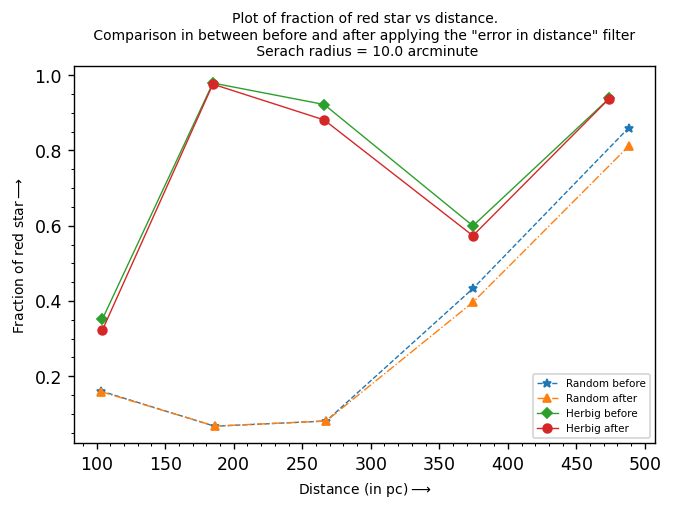

In [45]:
fig, ax = plt.subplots(dpi = 125)
ax.set_xlabel(r"Distance (in pc)$\longrightarrow$", fontsize = 8)
ax.set_ylabel(r"Fraction of red star$\longrightarrow$", fontsize = 8)

ax.plot(star5["r_med_photogeo"], frac_before_rand, '--', marker = "*", linewidth = 0.8, markersize = 5, label = "Random before")
ax.plot(star5["r_med_photogeo"], frac_after_rand, "-.", marker = "^", linewidth = 0.8, markersize = 5, label = "Random after")


ax.plot(herb5["Dist"], frac_before_herb, marker = "D", linewidth = 0.8, markersize = 4, label = "Herbig before")
ax.plot(herb5["Dist"], frac_after_herb, marker = "o", linewidth = 0.8, markersize = 5, label = "Herbig after")


ax.legend(fontsize = 6)
# ax.set_xscale("log")
ax.minorticks_on()
ax.set_title("""Plot of fraction of red star vs distance.\n Comparison in between before and after applying the "error in distance" filter \n Serach radius = {} arcminute""".format(rad_arcmin), fontsize = 8)
plt.show()